In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as path_effects

# Set up the notebook for better visualization
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 12)
plt.rcParams['font.size'] = 12

In [2]:
data_file = 'kiwi_simplified_data.pkl'  # Update this path if needed

with open(data_file, 'rb') as f:
    data = pickle.load(f)

hyperspectral_data = data['data']
metadata = data['metadata']

print("Metadata:")
for key, value in metadata.items():
    print(f"  {key}: {value}")

Metadata:
  processed_date: 2025-04-16 12:15:08
  cutoff_offset: 30
  reflectance_range: (400, 500)
  excitation_wavelengths: [300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500]
  valid_reflectance_excitations: [400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500]


In [3]:
excitation_keys = [key for key in hyperspectral_data.keys() if key != 'Reflectance']
excitation_wavelengths = [float(key) for key in excitation_keys]
excitation_wavelengths.sort()

print(f"\nAvailable excitation wavelengths: {excitation_wavelengths}")

emission_data = {}
max_intensity = 0

for ex_key in excitation_keys:
    ex_data = hyperspectral_data[ex_key]
    wavelengths = ex_data['wavelengths']
    cube = ex_data['cube']
    mean_spectrum = np.mean(cube, axis=(1, 2))

    emission_data[float(ex_key)] = {
        'wavelengths': wavelengths,
        'intensity': mean_spectrum
    }

    max_intensity = max(max_intensity, np.max(mean_spectrum))

print(f"Max intensity across all spectra: {max_intensity:.4f}")


Available excitation wavelengths: [300.0, 310.0, 320.0, 330.0, 340.0, 350.0, 360.0, 370.0, 380.0, 390.0, 400.0, 410.0, 420.0, 430.0, 440.0, 450.0, 460.0, 470.0, 480.0, 490.0, 500.0]
Max intensity across all spectra: 56.0691


In [19]:
all_emission_wavelengths = []
for ex, data in emission_data.items():
    all_emission_wavelengths.extend(data['wavelengths'])

min_emission = min(all_emission_wavelengths)
max_emission = max(all_emission_wavelengths)

# Create a regular grid for the EEM
resolution = 0.05  # nm resolution (adjust as needed)
emission_grid = np.arange(min_emission, max_emission + resolution, resolution)

print(f"Emission wavelength range: {min_emission:.1f} - {max_emission:.1f} nm")
print(f"EEM grid resolution: {resolution} nm")

Emission wavelength range: 401.4 - 1072.9 nm
EEM grid resolution: 0.0005 nm


In [20]:
eem_matrix = np.zeros((len(excitation_wavelengths), len(emission_grid)))
cutoff_mask = np.ones_like(eem_matrix, dtype=bool)  # Track cutoff regions

for i, ex in enumerate(excitation_wavelengths):
    ex_key = str(ex)
    ex_data = emission_data[ex]

    # Get this excitation's emission wavelengths and intensity
    ex_emission_wavelengths = ex_data['wavelengths']
    ex_intensity = ex_data['intensity']

    # For each point in the emission grid, find the corresponding intensity
    for j, em in enumerate(emission_grid):
        # If this emission wavelength is within the available range for this excitation
        if em >= ex_emission_wavelengths[0] and em <= ex_emission_wavelengths[-1]:
            # Find the two closest points for interpolation
            idx = np.searchsorted(ex_emission_wavelengths, em)
            if idx == 0:
                # At the beginning
                eem_matrix[i, j] = ex_intensity[0]
            elif idx == len(ex_emission_wavelengths):
                # At the end
                eem_matrix[i, j] = ex_intensity[-1]
            else:
                # Interpolate between two points
                weight = (em - ex_emission_wavelengths[idx-1]) / (ex_emission_wavelengths[idx] - ex_emission_wavelengths[idx-1])
                eem_matrix[i, j] = ex_intensity[idx-1] * (1 - weight) + ex_intensity[idx] * weight
        else:
            eem_matrix[i, j] = 0  # Outside the available range

        # Calculate cutoff mask
        # 1. Primary cutoff: emission < excitation + cutoff_offset
        if em < (ex + metadata['cutoff_offset']):
            cutoff_mask[i, j] = False

        # 2. Second-order cutoff: emission within ±cutoff_offset of 2*excitation
        second_order_min = 2 * ex - metadata['cutoff_offset']
        second_order_max = 2 * ex + metadata['cutoff_offset']
        if em >= second_order_min and em <= second_order_max:
            cutoff_mask[i, j] = False

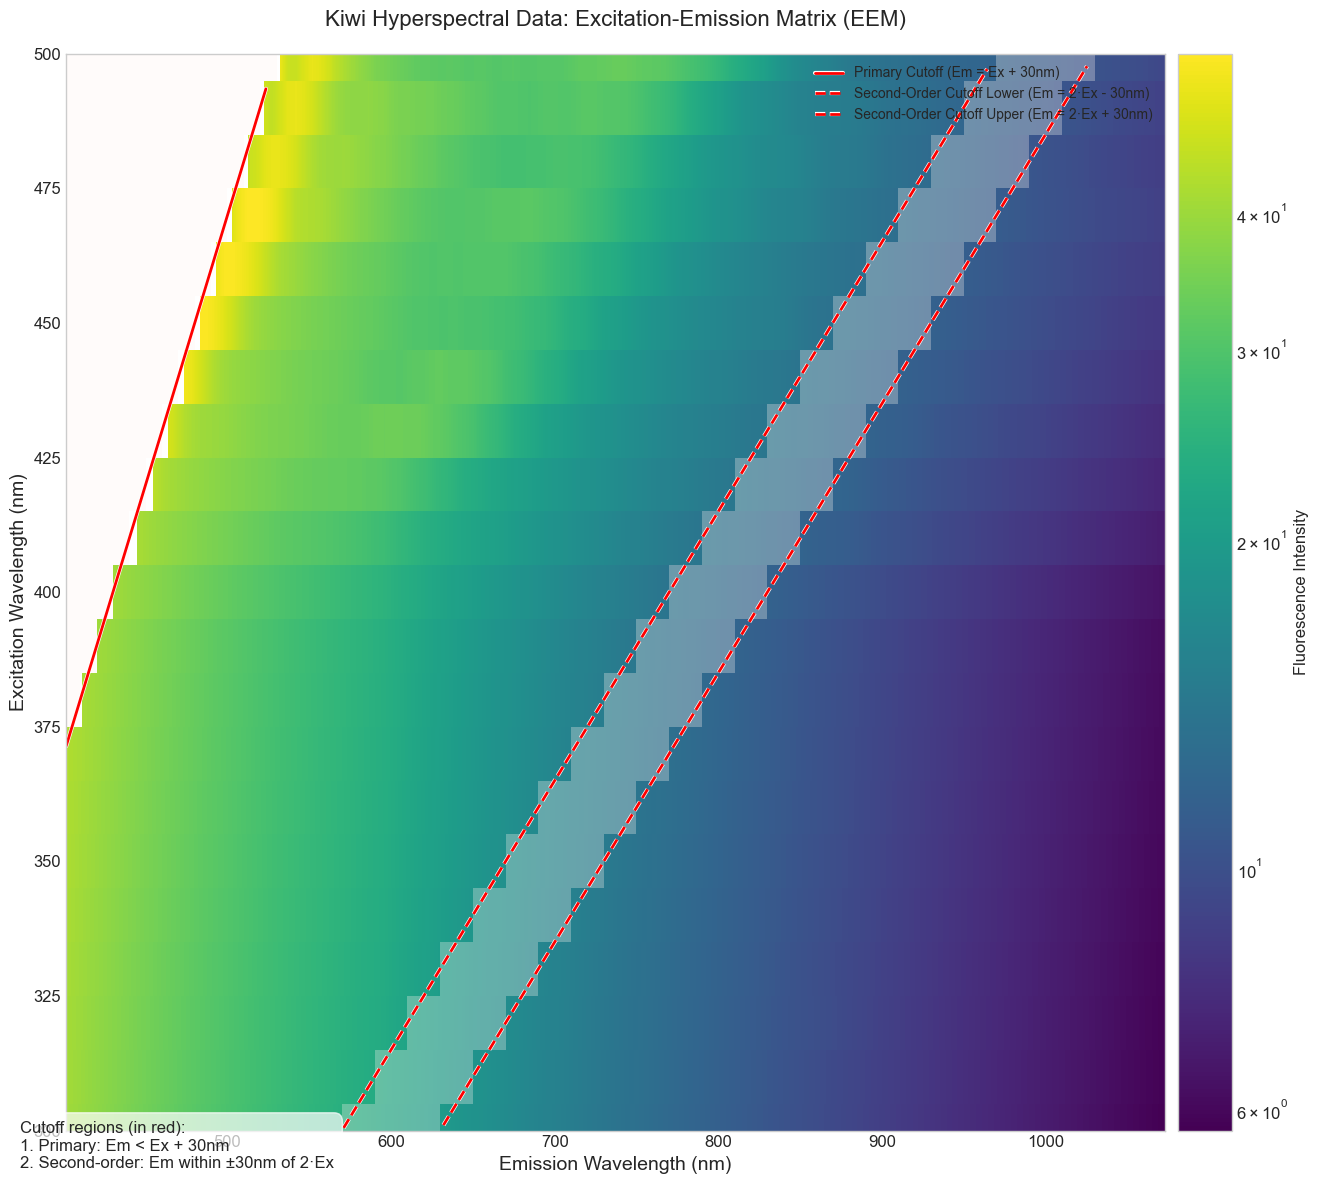

In [21]:
def create_eem_plot(eem_matrix, excitation_wavelengths, emission_grid, cutoff_mask,
                    title="Excitation-Emission Matrix (EEM) with Cutoff Regions",
                    log_scale=True, highlight_diagonals=True):
    """Create a beautiful EEM plot with cutoff regions highlighted"""

    # Set up the figure with gridspec for better control
    fig = plt.figure(figsize=(14, 12))
    gs = gridspec.GridSpec(1, 1)
    ax = plt.subplot(gs[0, 0])

    # For consistent color scaling
    if log_scale:
        # Add a small value to avoid log(0)
        norm = LogNorm(vmin=max(1e-3, np.min(eem_matrix[eem_matrix > 0])),
                       vmax=np.max(eem_matrix))
        cmap = 'viridis'
    else:
        norm = Normalize(vmin=0, vmax=np.max(eem_matrix))
        cmap = 'viridis'

    # Create the main EEM heatmap
    im = ax.pcolormesh(emission_grid, excitation_wavelengths, eem_matrix,
                     cmap=cmap, norm=norm, shading='auto')

    # Add a color bar
    cbar = plt.colorbar(im, ax=ax, pad=0.01)
    cbar.set_label('Fluorescence Intensity', fontsize=12)

    # Overlay the cutoff mask in red with transparency
    # Create a masked array for the cutoff regions
    masked_data = np.ma.masked_array(np.ones_like(eem_matrix), mask=cutoff_mask)
    ax.pcolormesh(emission_grid, excitation_wavelengths, masked_data,
                cmap='Reds', alpha=0.3, shading='auto')

    # Add diagonal lines to mark cutoff boundaries if requested
    if highlight_diagonals:
        # Primary cutoff line (excitation + offset)
        offset = metadata['cutoff_offset']
        x_primary = np.linspace(min_emission, max_emission, 100)
        y_primary = x_primary - offset
        # Only plot where y is within the excitation range
        mask = (y_primary >= min(excitation_wavelengths)) & (y_primary <= max(excitation_wavelengths))
        ax.plot(x_primary[mask], y_primary[mask], 'r-', linewidth=2,
                label=f'Primary Cutoff (Em = Ex + {offset}nm)',
                path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])

        # Second-order cutoff lines
        x_second = np.linspace(min_emission, max_emission, 100)
        y_second_lower = (x_second - offset) / 2
        y_second_upper = (x_second + offset) / 2

        # Only plot where y is within the excitation range
        mask_lower = (y_second_lower >= min(excitation_wavelengths)) & (y_second_lower <= max(excitation_wavelengths))
        mask_upper = (y_second_upper >= min(excitation_wavelengths)) & (y_second_upper <= max(excitation_wavelengths))

        if any(mask_lower):
            ax.plot(x_second[mask_lower], y_second_lower[mask_lower], 'r--', linewidth=2,
                    label=f'Second-Order Cutoff Lower (Em = 2·Ex - {offset}nm)',
                    path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])

        if any(mask_upper):
            ax.plot(x_second[mask_upper], y_second_upper[mask_upper], 'r--', linewidth=2,
                    label=f'Second-Order Cutoff Upper (Em = 2·Ex + {offset}nm)',
                    path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])

    # Set labels and title
    ax.set_xlabel('Emission Wavelength (nm)', fontsize=14)
    ax.set_ylabel('Excitation Wavelength (nm)', fontsize=14)
    ax.set_title(title, fontsize=16, pad=20)

    # Add legend
    ax.legend(loc='upper right', fontsize=10)

    # Set axis limits
    ax.set_xlim(min_emission, max_emission)
    ax.set_ylim(min(excitation_wavelengths), max(excitation_wavelengths))

    # Add grid
    ax.grid(color='white', linestyle='-', linewidth=0.5, alpha=0.7)

    # Add text annotation explaining cutoff regions
    cutoff_text = (f"Cutoff regions (in red):\n"
                  f"1. Primary: Em < Ex + {offset}nm\n"
                  f"2. Second-order: Em within ±{offset}nm of 2·Ex")
    plt.figtext(0.02, 0.02, cutoff_text, fontsize=12,
                bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.5'))

    plt.tight_layout()
    return fig, ax

# Create the EEM plot
fig, ax = create_eem_plot(eem_matrix, excitation_wavelengths, emission_grid, cutoff_mask,
                          title="Kiwi Hyperspectral Data: Excitation-Emission Matrix (EEM)",
                          log_scale=True)
plt.show()


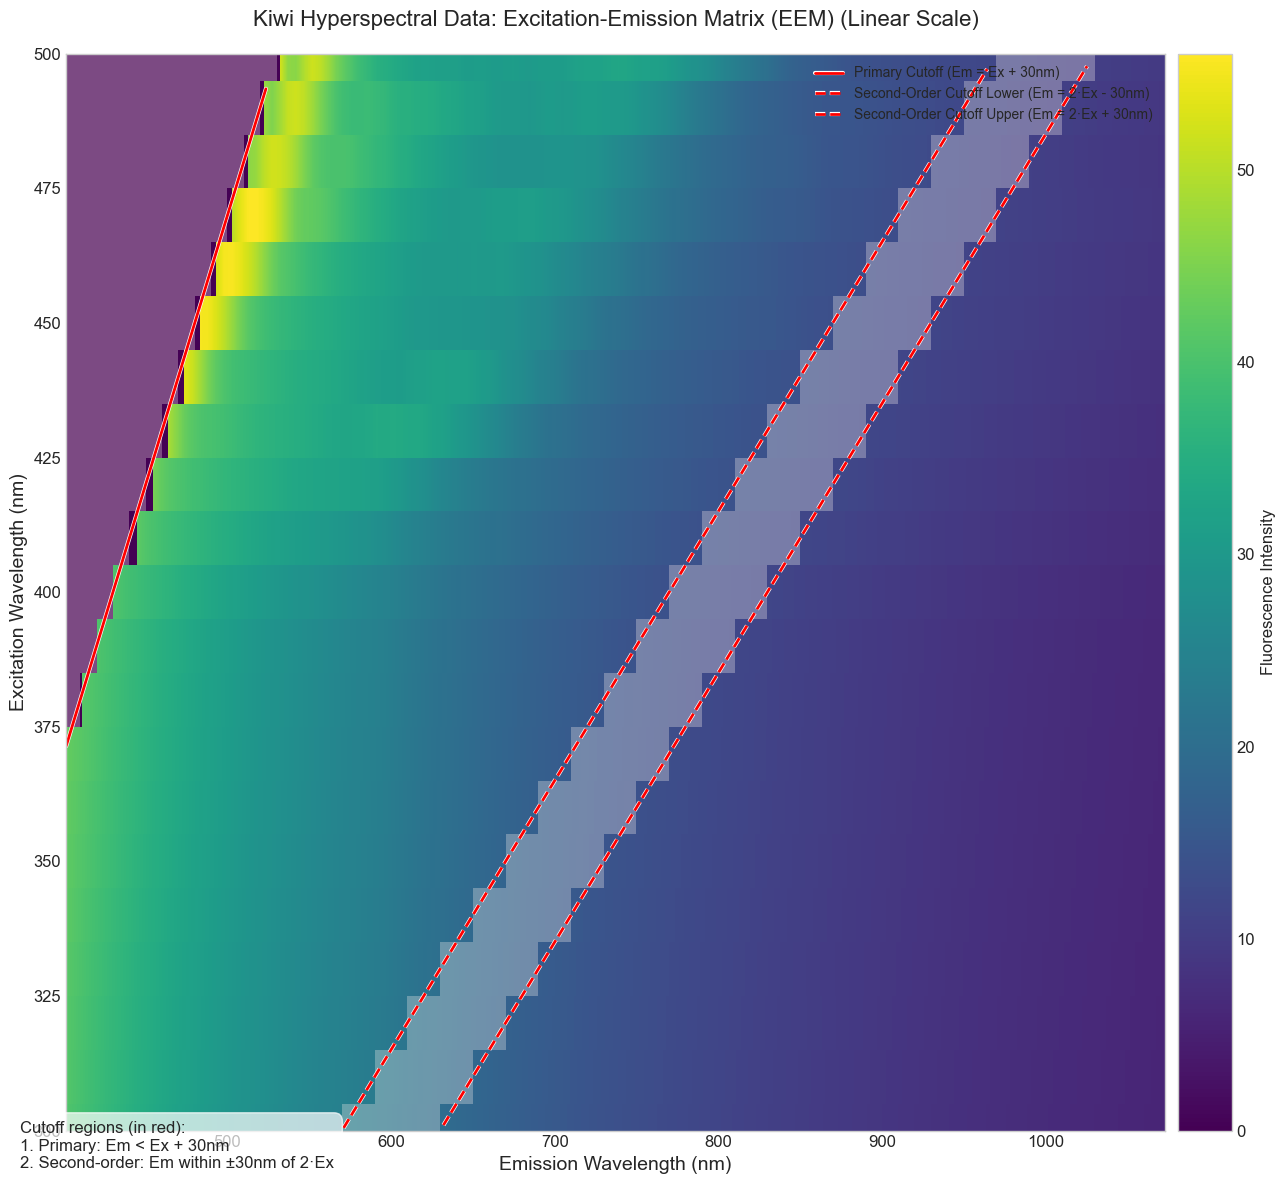

In [22]:
fig, ax = create_eem_plot(eem_matrix, excitation_wavelengths, emission_grid, cutoff_mask,
                          title="Kiwi Hyperspectral Data: Excitation-Emission Matrix (EEM) (Linear Scale)",
                          log_scale=False)
plt.show()

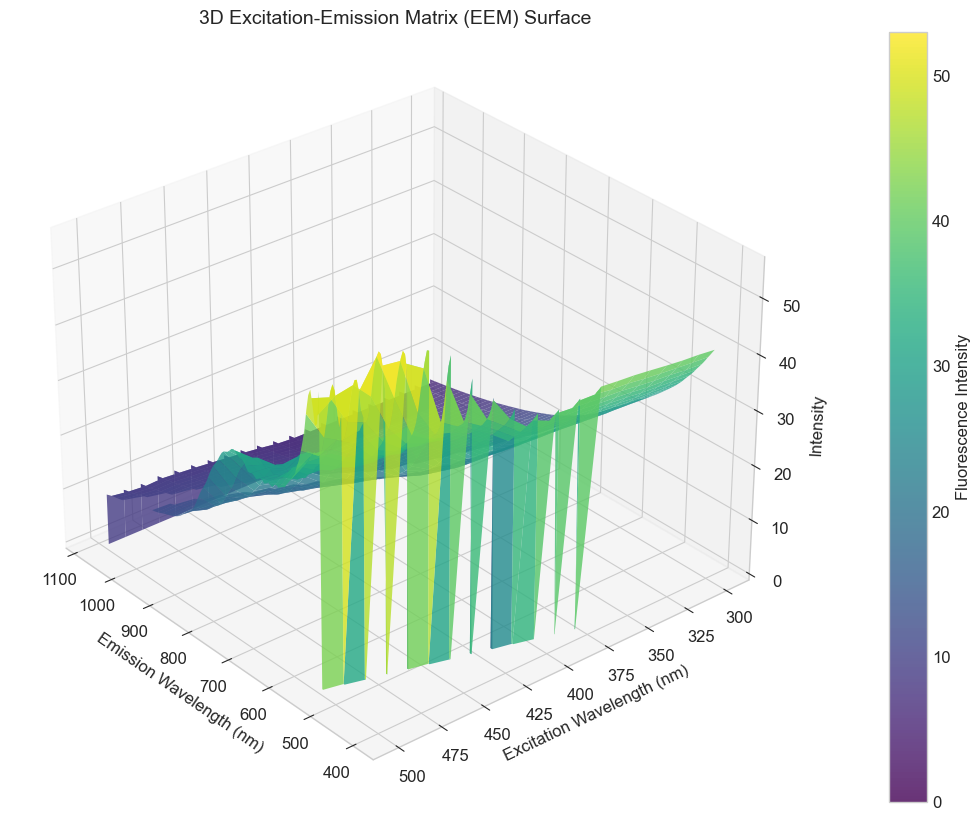

In [23]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def plot_eem_3d(eem_matrix, excitation_wavelengths, emission_grid, cutoff_mask):
    """Create a 3D surface plot of the EEM"""
    # Apply cutoff mask to the data
    masked_eem = np.copy(eem_matrix)
    masked_eem[~cutoff_mask] = np.nan  # Set cutoff regions to NaN

    # Create meshgrid for 3D plot
    X, Y = np.meshgrid(emission_grid, excitation_wavelengths)

    # Create the figure
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Create the surface plot
    surf = ax.plot_surface(X, Y, masked_eem, cmap='viridis',
                          linewidth=0, antialiased=True, alpha=0.8)

    # Add a color bar
    cbar = fig.colorbar(surf, ax=ax, pad=0.1)
    cbar.set_label('Fluorescence Intensity', fontsize=12)

    # Set labels and title
    ax.set_xlabel('Emission Wavelength (nm)', fontsize=12)
    ax.set_ylabel('Excitation Wavelength (nm)', fontsize=12)
    ax.set_zlabel('Intensity', fontsize=12)
    ax.set_title('3D Excitation-Emission Matrix (EEM) Surface', fontsize=14)

    # Set view angle for better visualization
    ax.view_init(elev=30, azim=140)

    return fig, ax

try:
    fig, ax = plot_eem_3d(eem_matrix, excitation_wavelengths, emission_grid, cutoff_mask)
    plt.show()
except Exception as e:
    print(f"Could not create 3D plot: {e}")